In [13]:
import sagemaker
import boto3

sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sess.default_bucket()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)
s3 = boto3.Session().client(service_name="s3", region_name=region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [14]:
!pip install imbalanced-learn

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [15]:
import pandas as pd

df = pd.read_csv('s3://ads508-20240325131610-mi4zt/training_data/')


In [5]:
df.head()

,price,freight_value,payment_installments,payment_value,review_score,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,...,order_status_canceled,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,124.99,21.88,2,146.87,4,1.0,8683.0,54.0,64.0,31.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,289.00,46.48,8,335.48,5,3.0,10150.0,89.0,15.0,40.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,139.94,17.79,7,157.73,5,1.0,8267.0,52.0,52.0,17.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,149.94,23.36,1,173.30,5,1.0,12160.0,56.0,51.0,28.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,230.00,22.25,8,252.25,5,1.0,5200.0,45.0,15.0,35.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
df.dtypes

price                       float64
freight_value               float64
payment_installments          int64
payment_value               float64
review_score                  int64
product_photos_qty          float64
product_weight_g            float64
product_length_cm           float64
product_height_cm           float64
product_width_cm            float64
churn                         int64
order_status_approved       float64
order_status_canceled       float64
order_status_delivered      float64
order_status_invoiced       float64
order_status_processing     float64
order_status_shipped        float64
order_status_unavailable    float64
payment_type_boleto         float64
payment_type_credit_card    float64
payment_type_debit_card     float64
payment_type_voucher        float64
dtype: object

In [17]:
import pandas as pd
df['product_volume_cm'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']

In [7]:
df = df.drop(columns =['product_length_cm', 'product_height_cm', 'product_width_cm'], axis=1)

In [18]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
X = df.drop(columns='churn')  # Features
y = df['churn']               # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=113)

smote = SMOTE(random_state=113)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


Accuracy: 0.97
F1 score: 0.98
Precision: 0.97
Recall: 0.99
AUC score: 0.71
Confusion matrix:
[[  362   919]
 [  309 33905]]
              precision    recall  f1-score   support

           0       0.54      0.28      0.37      1281
           1       0.97      0.99      0.98     34214

    accuracy                           0.97     35495
   macro avg       0.76      0.64      0.68     35495
weighted avg       0.96      0.97      0.96     35495



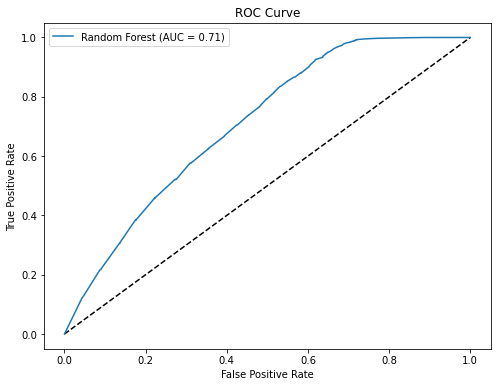

In [41]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# Train the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Calculate F1 score
f1_rf = f1_score(y_test, y_pred_rf)


# Calculate precision
precision_rf = precision_score(y_test, y_pred_rf)

# Calculate recall
recall_rf = recall_score(y_test, y_pred_rf)


# Calculate ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
auc_score_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

# Calculate confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Print the results
print(f"Accuracy: {accuracy_rf:.2f}")
print(f"F1 score: {f1_rf:.2f}")
print(f"Precision: {precision_rf:.2f}")
print(f"Recall: {recall_rf:.2f}")
print(f"AUC score: {auc_score_rf:.2f}")
print("Confusion matrix:")
print(conf_matrix_rf)
print(classification_report(y_test, y_pred_rf))



# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score_rf:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Feature Importances:
product_photos_qty: 0.124
payment_type_credit_card: 0.098
payment_value: 0.086
payment_type_boleto: 0.082
product_volume_cm: 0.076
freight_value: 0.075
product_weight_g: 0.075
price: 0.074
product_height_cm: 0.064
product_length_cm: 0.061
product_width_cm: 0.060
review_score: 0.039
payment_installments: 0.039
payment_type_voucher: 0.029
payment_type_debit_card: 0.008
order_status_delivered: 0.007
order_status_shipped: 0.003
order_status_canceled: 0.001
order_status_invoiced: 0.001
order_status_processing: 0.000
order_status_unavailable: 0.000
order_status_approved: 0.000


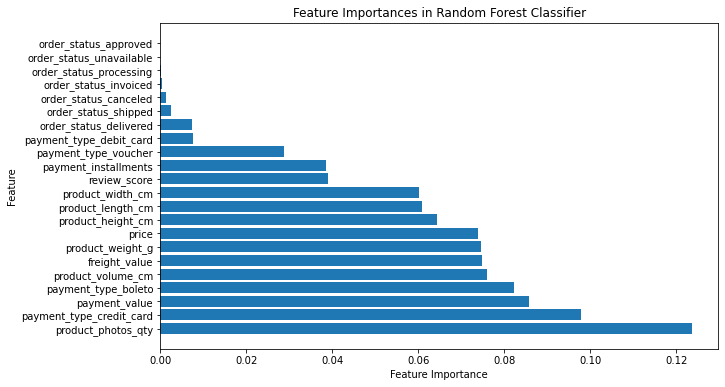

In [26]:
feature_names = X.columns
# Get the feature importances
feature_importances = rf_model.feature_importances_

# Sort the feature importances in descending order
sorted_feature_importances = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

# Print the feature importances
print("Feature Importances:")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance:.3f}")
    
# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in sorted_feature_importances], [x[1] for x in sorted_feature_importances], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Classifier')
plt.show()

In [21]:
!pip install xgboost

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


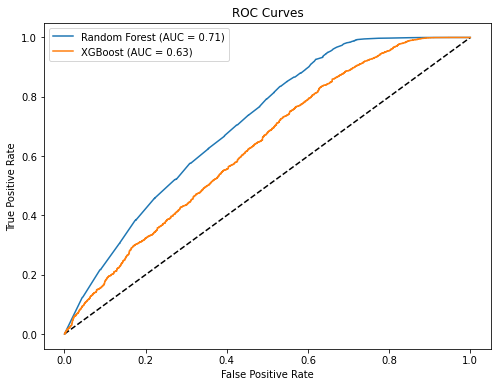

In [44]:
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Train the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_smote, y_train_smote)



# Train the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Calculate ROC and AUC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
auc_score_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

# Calculate ROC and AUC for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
auc_score_xgb = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_score_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_score_xgb:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()



Accuracy: 0.95
F1 score: 0.98
Precision: 0.97
Recall: 0.18
AUC score: 0.63
Confusion matrix:
[[  204  1077]
 [  538 33676]]
              precision    recall  f1-score   support

           0       0.27      0.16      0.20      1281
           1       0.97      0.98      0.98     34214

    accuracy                           0.95     35495
   macro avg       0.62      0.57      0.59     35495
weighted avg       0.94      0.95      0.95     35495

---------------------------------------------------------------
Feature Importances:
payment_type_credit_card: 0.397
payment_type_voucher: 0.104
product_photos_qty: 0.099
order_status_invoiced: 0.072
order_status_delivered: 0.052
review_score: 0.034
payment_type_boleto: 0.029
payment_type_debit_card: 0.027
product_width_cm: 0.025
product_height_cm: 0.024
product_length_cm: 0.021
payment_value: 0.019
order_status_canceled: 0.016
price: 0.015
freight_value: 0.015
product_weight_g: 0.014
payment_installments: 0.013
product_volume_cm: 0.012
order_

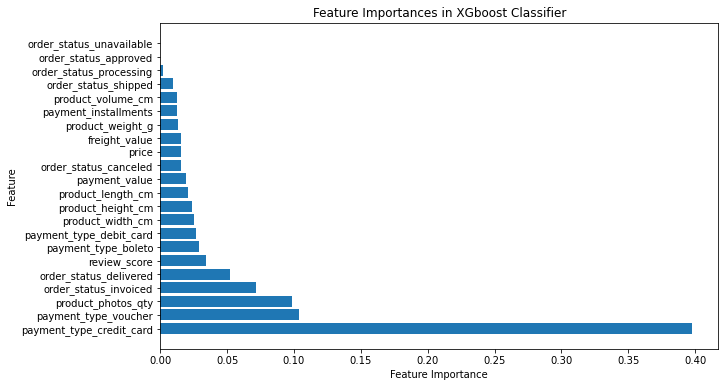

In [46]:
# Calculate accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

# Calculate F1 score
f1_xgb = f1_score(y_test, y_pred_xgb)

# Calculate precision
precision_xgb = precision_score(y_test, y_pred_nb)

# Calculate recall
recall_xgb = recall_score(y_test, y_pred_nb)


auc_score_xgb = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])



# Calculate confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Print the results
print(f"Accuracy: {accuracy_xgb:.2f}")
print(f"F1 score: {f1_xgb:.2f}")
print(f"Precision: {precision_xgb:.2f}")
print(f"Recall: {recall_xgb:.2f}")
print(f"AUC score: {auc_score_xgb:.2f}")
print("Confusion matrix:")
print(conf_matrix_xgb)
print(classification_report(y_test, y_pred_xgb))

print("---------------------------------------------------------------")


feature_names = X.columns
# Get the feature importances
feature_importances = xgb_model.feature_importances_

# Sort the feature importances in descending order
sorted_feature_importances = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

# Print the feature importances
print("Feature Importances:")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance:.3f}")

    

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in sorted_feature_importances], [x[1] for x in sorted_feature_importances], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in XGboost Classifier')
plt.show()

Accuracy: 0.20
F1 score: 0.30
Precision: 0.97
Recall: 0.18
AUC score: 0.48
Confusion matrix:
[[ 1067   214]
 [28166  6048]]
              precision    recall  f1-score   support

           0       0.04      0.83      0.07      1281
           1       0.97      0.18      0.30     34214

    accuracy                           0.20     35495
   macro avg       0.50      0.50      0.18     35495
weighted avg       0.93      0.20      0.29     35495



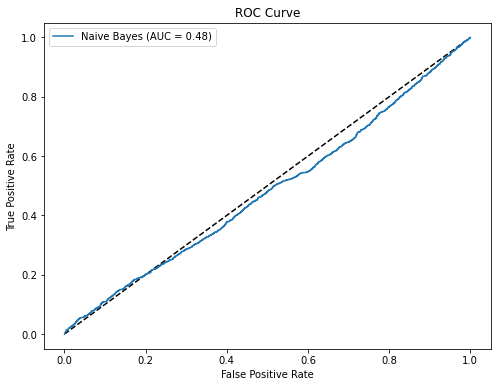

In [48]:
from sklearn.naive_bayes import GaussianNB
# Train the Naive Bayes classifier
nb_model = GaussianNB()
nb_model.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred_nb = nb_model.predict(X_test)

# Calculate accuracy
accuracy_nb = accuracy_score(y_test, y_pred_nb)

# Calculate F1 score
f1_nb = f1_score(y_test, y_pred_nb)

# Calculate precision
precision_nb = precision_score(y_test, y_pred_nb)


# Calculate recall
recall_nb = recall_score(y_test, y_pred_nb)


# Calculate ROC and AUC
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_model.predict_proba(X_test)[:, 1])
auc_score_nb = roc_auc_score(y_test, nb_model.predict_proba(X_test)[:, 1])

# Calculate confusion matrix
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

# Print the results
print(f"Accuracy: {accuracy_nb:.2f}")
print(f"F1 score: {f1_nb:.2f}")
print(f"Precision: {precision_nb:.2f}")
print(f"Recall: {recall_nb:.2f}")
print(f"AUC score: {auc_score_nb:.2f}")
print("Confusion matrix:")
print(conf_matrix_nb)
print(classification_report(y_test, y_pred_nb))


# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {auc_score_nb:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [35]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 37.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 39.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 9.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.8 MB/s eta 0:00:00:00:0100:01
   ━━━━

In [40]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Assuming X_train_smote, y_train_smote, X_test, and y_test are numpy arrays

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled).float()
X_test_tensor = torch.tensor(X_test_scaled).float()
# Convert and reshape the data
y_train_tensor = torch.tensor(y_train_smote.values.reshape(-1, 1)).float() if isinstance(y_train_smote, pd.Series) else torch.tensor(y_train_smote.reshape(-1, 1)).float()
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1)).float() if isinstance(y_test, pd.Series) else torch.tensor(y_test.reshape(-1, 1)).float()


# Create DataLoader for batch processing
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Neural network architecture
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(X_train_tensor.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

model = BinaryClassifier()

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
for epoch in range(10):
    for data in train_loader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Predict on the test set
with torch.no_grad():
    y_pred_nn = model(X_test_tensor)
    y_pred_nn = (y_pred_nn.numpy() > 0.5).astype(int)

# Evaluate the model
accuracy_nn = accuracy_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
auc_score_nn = roc_auc_score(y_test, y_pred_nn)

# Print the results
print(f"Accuracy: {accuracy_nn:.2f}")
print(f"F1 score: {f1_nn:.2f}")
print(f"Precision: {precision_nn:.2f}")
print(f"Recall: {recall_nn:.2f}")
print(f"AUC score: {auc_score_nn:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_nn))


Accuracy: 0.87
F1 score: 0.93
Precision: 0.97
Recall: 0.89
AUC score: 0.55
Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.22      0.11      1281
           1       0.97      0.89      0.93     34214

    accuracy                           0.87     35495
   macro avg       0.52      0.55      0.52     35495
weighted avg       0.94      0.87      0.90     35495

